In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [2]:
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [3]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'
# path = '/GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis'
# /GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis
# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [4]:
train.sample()

,Provider,PotentialFraud
3815,PRV55776,No


In [5]:
outpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
92711,BENE37444,CLM309947,2009-04-18,2009-05-08,PRV55013,30,PHY367576,NaN,NaN,2823,5853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [6]:
inpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
38736,BENE152988,CLM75013,2009-11-07,2009-11-10,PRV55232,5000,PHY407570,PHY379677,NaN,2009-11-07,78939,1068.0,2009-11-10,747,220,2859,53081,6262,25000,3051,42789,2448,6202,NaN,6831.0,NaN,NaN,NaN,NaN,NaN


In [7]:
inpatient['Provider'].nunique()

2092

In [8]:
df = inpatient.groupby('Provider')['InscClaimAmtReimbursed'].sum().reset_index().rename(columns={'InscClaimAmtReimbursed': 'TotalReimbursment'})
df

,Provider,TotalReimbursment
0,PRV51001,97000
1,PRV51003,573000
2,PRV51007,19000
3,PRV51008,25000
4,PRV51011,5000
...,...,...
2087,PRV57719,76000
2088,PRV57728,6000
2089,PRV57729,107000
2090,PRV57732,76000


In [9]:
df = df.merge(train, how='left', on='Provider')

In [10]:
df

,Provider,TotalReimbursment,PotentialFraud
0,PRV51001,97000,No
1,PRV51003,573000,Yes
2,PRV51007,19000,No
3,PRV51008,25000,No
4,PRV51011,5000,No
...,...,...,...
2087,PRV57719,76000,No
2088,PRV57728,6000,No
2089,PRV57729,107000,No
2090,PRV57732,76000,No


In [11]:
df['PotentialFraud'] = df['PotentialFraud'].map({'Yes': 1, 'No': 0})
df

,Provider,TotalReimbursment,PotentialFraud
0,PRV51001,97000,0
1,PRV51003,573000,1
2,PRV51007,19000,0
3,PRV51008,25000,0
4,PRV51011,5000,0
...,...,...,...
2087,PRV57719,76000,0
2088,PRV57728,6000,0
2089,PRV57729,107000,0
2090,PRV57732,76000,0


In [12]:
# feature total amount reimbursed by by the insurance per provider:
X = df[['TotalReimbursment']]
X


,TotalReimbursment
0,97000
1,573000
2,19000
3,25000
4,5000
...,...
2087,76000
2088,6000
2089,107000
2090,76000


In [13]:
# target value (True or False), when 1 == Yes, and 0 == No.
y = df['PotentialFraud']
type(y)

pandas.core.series.Series

In [14]:
# 1. Split the data: 80% for training, 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [15]:
# 2. Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# 3. Fit the model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [17]:
# 4. Make prediction on the test 
y_pred = model.predict(X_test)
# 4.a Make probability 
y_proba = model.predict_proba(X_test)[:, 1]
print('y_pred: ', y_pred[:5])
print('y_proba: ', y_proba[:5])

y_pred:  [0 0 0 0 0]
y_proba:  [0.15804972 0.3640873  0.07024898 0.11267013 0.09428287]


In [18]:
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{cm}')

Confusion Matrix:
[[310  23]
 [ 53  33]]


In [19]:
from sklearn.metrics import  precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2}')
precicion = precision_score(y_test, y_pred)
print(f'precision: {precicion:.2}')
recall = recall_score(y_test,y_pred)
print(f'recall: {recall:.2}')
f1 = f1_score(y_test,y_pred)
print(f'f1 score: {f1:.2}')

Accuracy: 0.82
precision: 0.59
recall: 0.38
f1 score: 0.46


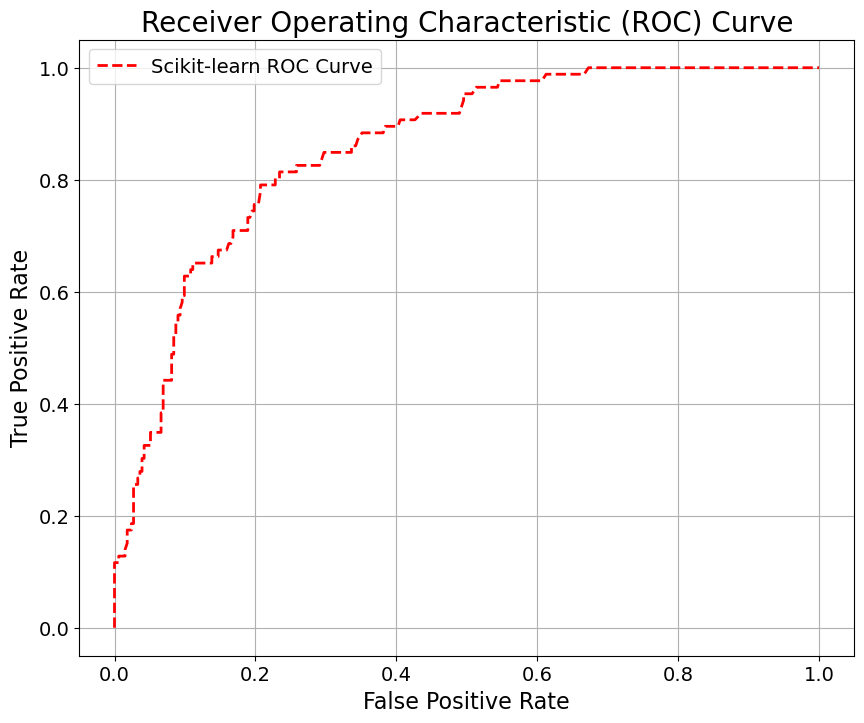

In [20]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [21]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.8567637404846709)

In [22]:
TN, FP, FN, TP = cm.ravel()


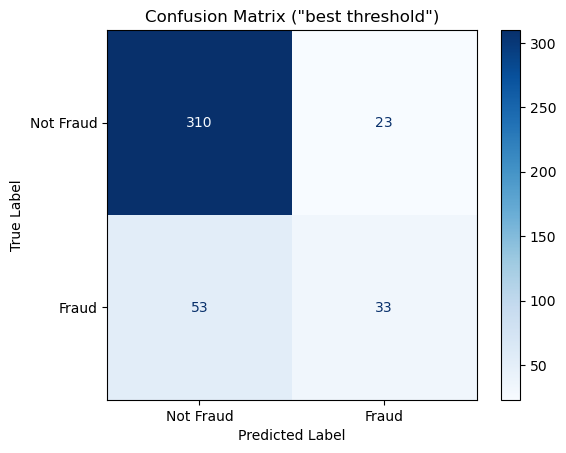

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix ("best threshold")')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [24]:
X_test

array([[-1.20438862e-01],
       [ 3.51224772e-01],
       [-5.05359760e-01],
       [-2.85792206e-01],
       [-3.69824232e-01],
       [-2.29138355e-01],
       [-4.53856259e-01],
       [-5.08070470e-01],
       [-5.24334733e-01],
       [-4.97227628e-01],
       [-3.75245654e-01],
       [-4.29459864e-01],
       [-3.75245654e-01],
       [-3.09854144e-02],
       [-4.53856259e-01],
       [-4.83674075e-01],
       [-4.64699101e-01],
       [-4.86384786e-01],
       [ 1.81500847e+00],
       [-4.99938339e-01],
       [ 4.16823967e-01],
       [-2.72238653e-01],
       [-2.55974390e-01],
       [-4.34881285e-01],
       [-4.94516917e-01],
       [-4.69786067e-02],
       [-2.39710126e-01],
       [-4.43013417e-01],
       [-3.96931338e-01],
       [-6.62246515e-02],
       [-2.61341596e-01],
       [-1.83598418e-01],
       [-4.32170575e-01],
       [-3.34584995e-01],
       [ 9.04209723e-01],
       [-5.24334733e-01],
       [-5.18913312e-01],
       [-5.05359760e-01],
       [-5.1

### loooking for a better threshold to find better f1 score:

In [25]:
model.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,

In [26]:
# Get predicted probabilities
y_proba = model.predict_proba(X_test)[:, 1]

In [27]:
y_proba

array([0.15804972, 0.3640873 , 0.07024898, 0.11267013, 0.09428287,
       0.12677194, 0.07863043, 0.06983154, 0.06737475, 0.07151517,
       0.093194  , 0.08291207, 0.093194  , 0.18826574, 0.07863043,
       0.07367237, 0.07679314, 0.0732362 , 0.94800061, 0.07109078,
       0.40069432, 0.11591376, 0.11991294, 0.08194264, 0.07194189,
       0.18255519, 0.12403073, 0.08050783, 0.08895058, 0.17586266,
       0.11858021, 0.13917753, 0.08242606, 0.10164197, 0.67912252,
       0.06737475, 0.06818464, 0.07024898, 0.06818464, 0.95532784,
       0.07863043, 0.10341106, 0.08947132, 0.15635153, 0.18924712,
       0.15134609, 0.0754411 , 0.07499529, 0.31251512, 0.1058122 ,
       0.09989977, 0.09373702, 0.3152756 , 0.07499529, 0.10460555,
       0.08349873, 0.16945482, 0.07770681, 0.98196167, 0.07367237,
       0.14970712, 0.30160682, 0.08538144, 0.08538144, 0.06859296,
       0.39271857, 0.15458446, 0.06859296, 0.37303595, 0.08050783,
       0.06737475, 0.14463983, 0.17866666, 0.13263082, 0.08252

In [28]:
from sklearn.metrics import precision_recall_curve

# Compute precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Find the threshold that maximizes F1-score
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Optimal threshold based on F1-score: {best_threshold}")

Optimal threshold based on F1-score: 0.23287536008327392


In [29]:
precicions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precicions * recalls) / (precicions + recalls)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Optimal threshold based on F1-score: {best_threshold}")

Optimal threshold based on F1-score: 0.23287536008327392


In [30]:
precicions

array([0.2052506 , 0.20574163, 0.20623501, 0.20823245, 0.21130221,
       0.215     , 0.21772152, 0.21882952, 0.21994885, 0.22222222,
       0.22631579, 0.22933333, 0.2311828 , 0.23306233, 0.23497268,
       0.2369146 , 0.23888889, 0.24089636, 0.24571429, 0.24855491,
       0.24927536, 0.25146199, 0.25368732, 0.25903614, 0.26219512,
       0.26299694, 0.26625387, 0.27044025, 0.27301587, 0.27388535,
       0.27741935, 0.27687296, 0.28052805, 0.28145695, 0.2852349 ,
       0.28619529, 0.28813559, 0.28911565, 0.29109589, 0.29209622,
       0.29411765, 0.29370629, 0.29473684, 0.29681979, 0.29893238,
       0.3       , 0.30107527, 0.30769231, 0.30882353, 0.31226766,
       0.31578947, 0.31439394, 0.31800766, 0.31923077, 0.32421875,
       0.32677165, 0.32669323, 0.328     , 0.32931727, 0.33198381,
       0.32926829, 0.32644628, 0.32916667, 0.33333333, 0.33905579,
       0.34051724, 0.34199134, 0.34497817, 0.34649123, 0.34801762,
       0.35111111, 0.35267857, 0.35454545, 0.35616438, 0.36111

In [31]:
recalls

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.98837209, 0.98837209, 0.98837209, 0.98837209,
       0.98837209, 0.98837209, 0.98837209, 0.98837209, 0.98837209,
       0.98837209, 0.97674419, 0.97674419, 0.97674419, 0.97674419,
       0.97674419, 0.97674419, 0.97674419, 0.97674419, 0.97674419,
       0.97674419, 0.96511628, 0.96511628, 0.96511628, 0.96511628,
       0.96511628, 0.95348837, 0.95348837, 0.95348837, 0.95348837,
       0.94186047, 0.91860465, 0.91860465, 0.91860465, 0.91860465,
       0.91860465, 0.91860465, 0.91860465, 0.91860465, 0.91860465,
       0.91860465, 0.91860465, 0.90697674, 0.90697674, 0.90697

In [32]:
thresholds

array([0.06617664, 0.06697316, 0.06737475, 0.06777857, 0.06818464,
       0.06859296, 0.06900354, 0.0694164 , 0.06983154, 0.07024898,
       0.07066872, 0.07109078, 0.07151517, 0.07194189, 0.07237097,
       0.0728024 , 0.0732362 , 0.07367237, 0.07411094, 0.07437524,
       0.07455191, 0.07499529, 0.0754411 , 0.07588933, 0.07634001,
       0.07679314, 0.07770681, 0.07816737, 0.07825978, 0.07863043,
       0.07909599, 0.07956407, 0.08003468, 0.08050783, 0.08098354,
       0.0814618 , 0.08194264, 0.08242606, 0.08252305, 0.08291207,
       0.08340069, 0.08349873, 0.08389193, 0.08438579, 0.08453447,
       0.08488229, 0.08538144, 0.08638773, 0.0868949 , 0.08740475,
       0.08843258, 0.08895058, 0.08926269, 0.08947132, 0.0899948 ,
       0.09052104, 0.09158184, 0.09211642, 0.0926538 , 0.09269691,
       0.093194  , 0.09373702, 0.09428287, 0.09538313, 0.09593756,
       0.09604879, 0.09705506, 0.09818416, 0.0987531 , 0.09989977,
       0.10047753, 0.10105826, 0.10129139, 0.10164197, 0.10222

In [33]:
# apply the new best threshold to the predicted probabilities
y_pred_custom = (y_proba >= best_threshold).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[296  37]
 [ 30  56]]


In [34]:
from sklearn.metrics import  precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred_custom)
print(f'Accuracy: {accuracy:.2}')
precicion = precision_score(y_test, y_pred_custom)
print(f'precision: {precicion:.2}')
recall = recall_score(y_test,y_pred_custom)
print(f'recall: {recall:.2}')
f1 = f1_score(y_test,y_pred_custom)
print(f'f1 score: {f1:.2}')

Accuracy: 0.84
precision: 0.6
recall: 0.65
f1 score: 0.63
